#  Butterfly classifier system 


The dataset with butterflies that will be used is retrieved from (XXX). The dataset consisting of YY movie posters devided between YY folders, labelled YY.

In [4]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.models import Model  
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.python.tools import module_util as _module_util
from tensorflow.python.util.lazy_loader import LazyLoader as _LazyLoader
from tensorflow.python.eager import context
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
import tarfile
import time
%matplotlib inline
import random
import pickle
import json
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot
import pickle
from sklearn.decomposition import PCA
from scipy.spatial import distance
import rasterfairy
import gradio as gr

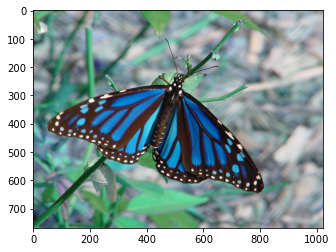

In [5]:
DATADIR = r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\train'
CATEGORIES = ["001Danaus_plexippus", "002Heliconius_charitonius", "003Heliconius_erato","004Junonia_coenia","005Lycaena_phlaeas","006Nymphalis_antiopa","007Papilio_cresphontes","008Pieris_rapae","009Vanessa_atalanta","010Vanessa_cardui"]

for category in CATEGORIES:
    path = os.path.join(DATADIR, category) #path to the different categories
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.show()
        break
    break

In [6]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [7]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We'll load the image of movie poster and take a look at its data vector.

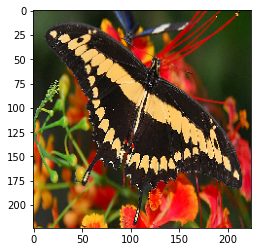

In [8]:
img, x = load_image(r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\train\007Papilio_cresphontes\0070065.png')
plt.imshow(img)

In [9]:
predictions = model.predict(x)
 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted admiral with probability 0.739
predicted sulphur_butterfly with probability 0.095
predicted monarch with probability 0.081
predicted ringlet with probability 0.042
predicted lycaenid with probability 0.009


In [10]:
feat_extractor_model = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

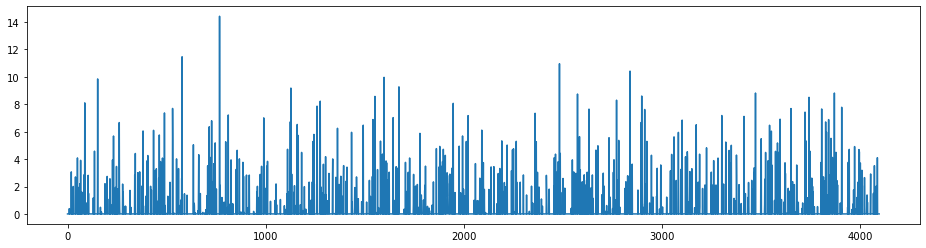

In [11]:
img, x = load_image(r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\train\007Papilio_cresphontes\0070065.png')
feat = feat_extractor_model.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [12]:
images_path = r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\train'
image_extensions = ['.jpg', '.png', '.jpeg']
max_num_images = 2000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1516 images to analyze


In [13]:
tic = time.process_time()

features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.process_time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.process_time()
    img, x = load_image(image_path);
    feat = feat_extractor_model.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 1516. Time: 0.0000 seconds.
analyzing image 500 / 1516. Time: 587.7344 seconds.
analyzing image 1000 / 1516. Time: 560.8906 seconds.
analyzing image 1500 / 1516. Time: 563.7656 seconds.
finished extracting features for 1516 images


In [14]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(n_components=300)

In [15]:
pca_features = pca.transform(features)

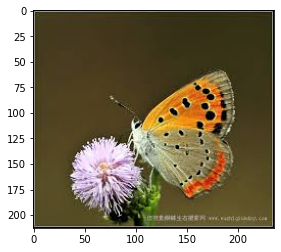

In [16]:
#Random image
query_image_idx = int(len(images) * random.random())

#Display image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [17]:
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [18]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:2]

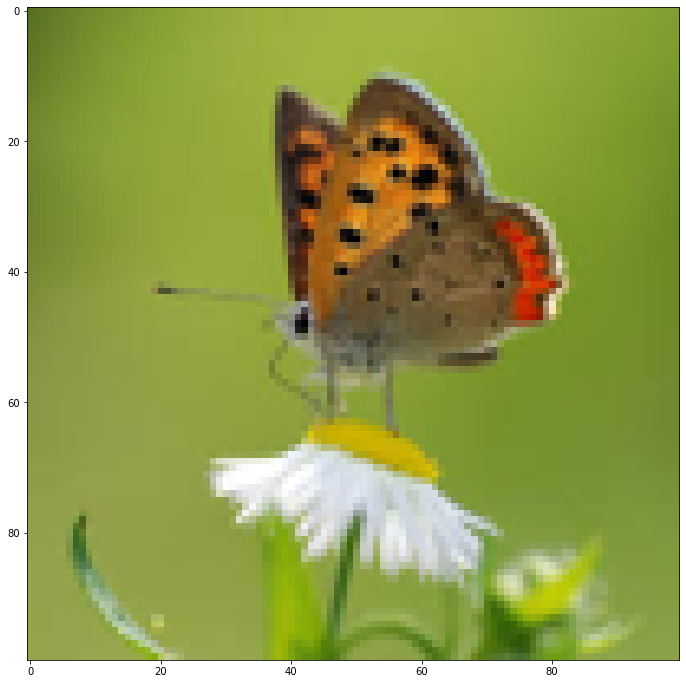

In [19]:
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

#concatenate the images
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

#show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [20]:
pickle.dump([images, pca_features, pca], open('butterflyfeatures.pickle', 'wb'))

## GRADIO INTERFACE
in order to work it requires a folder save of the input image - make sure to update the link with the destination 

In [24]:
# Input defined
image_in = gr.inputs.Image(source="upload", tool="editor", image_mode="RGB", type="pil")

# Define the parent function that will be called by the interface; whatever is the argument, that needs to be used inside the function
# in this case my_image

def predict_image(my_image):
    
    # save the input image to folder
    my_new_image = my_image.save( r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\train\image_in.png', 'PNG')
    
    def get_closest_images(query_image_idx, num_results=1):
        distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
        idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
        return idx_closest
    
    def get_concatenated_images(indexes, thumb_height):
        thumbs = []
        for idx in indexes:
            img = image.load_img(images[idx])
            img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
            thumbs.append(img)
        concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
        return concat_image

    query_image_idx = int(len(images) * random.random())
    idx_closest = get_closest_images(query_image_idx)
    query_image = get_concatenated_images([query_image_idx], 300)
    results_image = get_concatenated_images(idx_closest, 200)
    
    # use the image saved above as my_new_image as input for prediction predict
    new_image, x = load_image(r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\train\image_in.png')

    #new_image, x = uploaded_img
    new_features = feat_extractor_model.predict(x)

    # project it into pca space
    new_pca_features = pca.transform(new_features)[0]

    # calculate its distance
    distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:2]  # grab just the first 1
    results_image = get_concatenated_images(idx_closest, 200)
    
    return results_image

# defining the output for the interface
image_out = gr.outputs.Image(type="pil")

examples =  [
    [r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\examples\outline1.jpeg'],
    [r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\examples\outline2.jpeg'],
    [r'D:\03_AAU_Masters\02_2nd_semester\Semester project sem II\training\examples\outline3.jpeg'],
]

gr.Interface(fn=predict_image,
             title='Butterflies Sketching',
             description='You can upload a butterfly image from the examples, draw on top of it and and then press submit to find the butterfly that looks most similar.',
             inputs = image_in,
             # the live makes it easy to see suggestions in a real time
             # share creates the link to share the interface
             outputs = image_out, interpretation="default", examples = examples, allow_flagging=False).launch(share=True);

Running locally at: http://127.0.0.1:7863/
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://24349.gradio.app
Interface loading below...


Socket exception: An existing connection was forcibly closed by the remote host (10054)
Socket exception: An existing connection was forcibly closed by the remote host (10054)


In [ ]:
[images, pca_features, pca] = pickle.load(open('butterflyfeatures.pickle', 'rb'))

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

In [25]:
num_images_to_show = 20000

if len(images) > num_images_to_show:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_show))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [26]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=1000, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1515 samples in 0.043s...
[t-SNE] Computed neighbors for 1515 samples in 1.373s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1515
[t-SNE] Computed conditional probabilities for sample 1515 / 1515
[t-SNE] Mean sigma: 16.255963
[t-SNE] Computed conditional probabilities in 0.101s
[t-SNE] Iteration 50: error = 80.9239349, gradient norm = 0.2168474 (50 iterations in 2.014s)
[t-SNE] Iteration 100: error = 80.7596588, gradient norm = 0.2204072 (50 iterations in 1.685s)
[t-SNE] Iteration 150: error = 81.8855820, gradient norm = 0.2139695 (50 iterations in 1.655s)
[t-SNE] Iteration 200: error = 81.3335419, gradient norm = 0.2131999 (50 iterations in 1.603s)
[t-SNE] Iteration 250: error = 81.8257141, gradient norm = 0.2155788 (50 iterations in 1.690s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.825714
[t-SNE] Iteration 300: error = 1.2967716, gradient norm = 0.0052758 (50 iterations in 1.104s

In [27]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

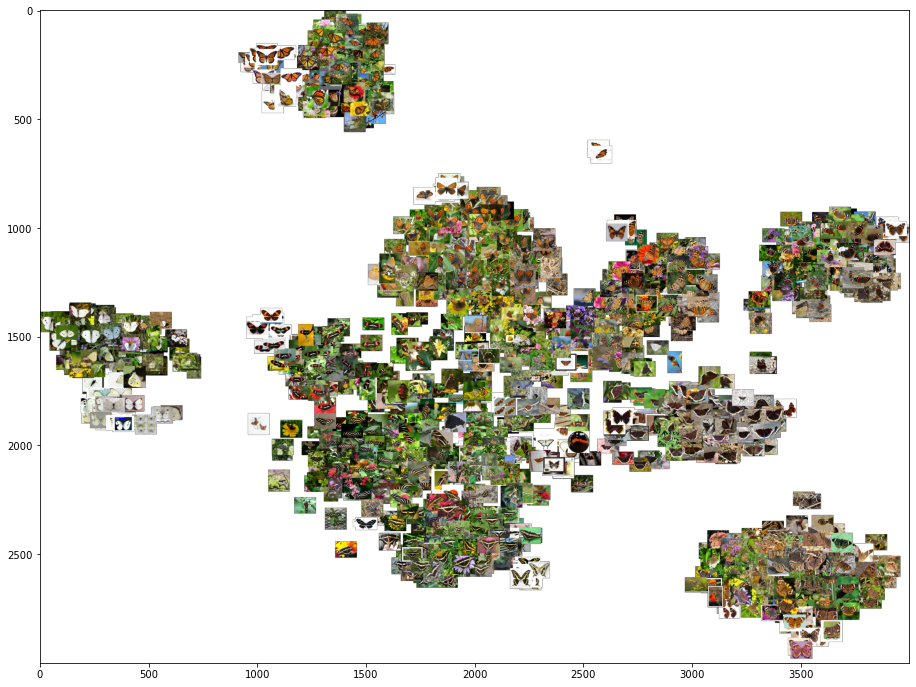

In [28]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [29]:
full_image.save("/Users/mirelastoian/Documents/Notebooks - butterflies/output_notebook/example-tSNE-Butterflies-Perplexity30-learningrate100016.png")

In [30]:
tsne_path = "/Users/mirelastoian/Documents/Notebooks - butterflies/output_notebook/example-tSNE-points-Butterflies1.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to /Users/mirelastoian/Documents/Notebooks - butterflies/output_notebook/example-tSNE-points-Butterflies1.json


In [31]:
# nx * ny = 1000, the number of images
nx = 101
ny = 15

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

In [ ]:
tile_width = 144
tile_height = 112

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [ ]:
grid_image.save("/Users/mirelastoian/Documents/Notebooks - butterflies/output_notebook/example-tSNE-Butterflies-grid201.png")